# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 2: Clasificación de Dígitos Manuscritos con Redes Neuronales**

### Estudiante: Joaquín Briones

El objetivo de esta tarea es utilizar redes neuronales en un problema de clasificación de dígitos. Se utilizará el conjunto de datos Optical Recognition of Handwritten Digits Data Set. Este conjunto tiene 64 características, con 10 clases y 5620 muestras en total. La base de datos estará disponible en U-Campus.

Las redes a ser entrenadas tienen la siguiente estructura: capa de entrada de dimensionalidad 64 (correspondiente a los datos de entrada), capas ocultas (una o dos) y capa de salida con 10 neuronas y función de activación softmax. La función de loss (pérdida) es entropía cruzada. El optimizador que se
debe usar es Adam. La función softmax está implícita al usar la función de pérdida CrossEntropyLoss de PyTorch (**no se debe agregar softmax a la salida de la red**).

Se usará PyTorch para entrenar y validar la red neuronal que implementa el clasificador de dígitos. Se analizará los efectos de cambiar el tamaño de la red (número de capas ocultas y de neuronas en estas
capas) y la función de activación.

El siguiente código base debe ser usado para realizar las actividades pedidas.

## Observación: Antes de ejecutar su código, active el uso de GPU en Google Colab para acelerar el proceso de entrenamiento.

### Para esto: vaya a "Entorno de Ejecución" en el menú superior, haga click en "Cambiar tipo de entorno de ejecución", y seleccionar/verificar "GPU" en "Acelerador de Hardware"

In [26]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


## Subir datasets de dígitos (train)

In [27]:
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt

--2023-10-18 14:41:03--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640604 (626K) [text/plain]
Saving to: ‘1_digits_train.txt.1’

1_digits_train.txt. 100%[===================>] 625.59K  --.-KB/s    in 0.03s   

2023-10-18 14:41:03 (19.0 MB/s) - ‘1_digits_train.txt.1’ saved [640604/640604]

--2023-10-18 14:41:03--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response...

## Leer dataset de dígitos

In [28]:
column_names = ["feat" + str(i) for i in range(64)]
column_names.append("class")

In [29]:
df_train_val = pd.read_csv('1_digits_train.txt', names = column_names)
df_train_val

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,0,0,9,11,0,0,0,0,0,7,...,0,0,0,8,12,12,15,10,0,2
4343,0,0,6,15,2,0,0,0,0,0,...,0,0,0,7,16,16,10,1,0,6
4344,0,0,15,16,16,14,0,0,0,0,...,0,0,0,14,11,0,0,0,0,7
4345,0,0,0,1,15,11,0,0,0,0,...,0,0,0,0,1,16,10,0,0,4


In [30]:
df_test = pd.read_csv('1_digits_test.txt', names = column_names)
df_test

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,13,12,10,12,8,0,0,2,...,0,0,0,10,16,16,8,0,0,5
1,0,0,8,16,14,4,0,0,0,5,...,0,0,0,10,16,14,12,2,0,9
2,0,0,0,7,16,0,0,0,0,0,...,0,0,0,0,9,15,1,0,0,4
3,0,0,2,14,9,2,0,0,0,0,...,0,0,0,2,14,14,2,0,0,0
4,0,1,16,16,15,3,0,0,0,0,...,0,0,0,16,6,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,0,0,5,13,11,2,0,0,0,2,...,0,0,0,8,13,15,10,1,0,9
1268,0,0,0,1,12,1,0,0,0,0,...,0,0,0,0,4,9,0,0,0,4
1269,0,0,3,15,0,0,0,0,0,0,...,0,0,0,4,14,16,9,0,0,6
1270,0,0,6,16,2,0,0,0,0,0,...,0,0,0,5,16,16,16,5,0,6


In [31]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)

In [32]:
scaler = StandardScaler().fit(df_train.iloc[:,0:64])
df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
df_test.iloc[:,0:64] = scaler.transform(df_test.iloc[:,0:64])

<ipython-input-32-9f48500b620a>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
<ipython-input-32-9f48500b620a>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
<ipython-input-32-9f48500b620a>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if colu

In [33]:
df_train

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
4026,0.0,-0.338570,0.797238,0.535297,-0.599203,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,-0.302452,0.078492,-0.427291,0.468026,1.548367,0.696964,-0.186744,9
1548,0.0,-0.338570,-0.269346,0.999221,0.985819,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.121990,0.248408,0.876852,1.378118,-0.527715,-0.186744,3
1709,0.0,-0.338570,-0.482663,0.535297,0.759387,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.723436,-0.427291,0.876852,1.548367,-0.037843,-0.186744,1
2195,0.0,2.026364,1.863823,-0.392551,-2.410657,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,1.890776,1.481867,-0.652523,-0.758451,0.356618,1.186836,-0.186744,2
1216,0.0,2.026364,0.797238,0.767259,0.985819,1.661897,0.191388,-0.13043,-0.045374,2.953365,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.672439,0.356618,-0.282779,-0.186744,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,0.0,-0.338570,-1.122613,-2.248248,-0.599203,1.839863,0.493359,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-1.124400,-2.679617,0.468026,-0.664881,-0.527715,-0.186744,9
1180,0.0,0.843897,0.583922,-0.392551,0.532956,0.772065,-0.412556,-0.13043,-0.045374,3.278195,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.468026,0.867368,0.452028,-0.186744,3
3441,0.0,-0.338570,-0.269346,-0.160589,0.985819,0.950031,-0.110584,-0.13043,-0.045374,0.354728,...,-0.206188,0.0,-0.302452,0.078492,0.473640,-2.393755,-1.175631,-0.527715,-0.186744,9
1344,0.0,-0.338570,1.223872,0.999221,0.985819,0.238166,-0.412556,-0.13043,-0.045374,0.029899,...,0.911859,0.0,-0.302452,0.880421,0.924106,0.876852,1.548367,3.391260,6.008192,2


## Crear modelo

In [34]:
model_a= nn.Sequential(
          nn.Linear(64, 10),
          nn.ReLU(),
          nn.Linear(10,10)
        )

In [35]:
model_b = nn.Sequential(
    nn.Linear(64, 40),
    nn.ReLU(),
    nn.Linear(40, 10)
)

In [36]:
model_c = nn.Sequential(
    nn.Linear(64, 10),
    nn.Tanh(),
    nn.Linear(10, 10)
)

In [37]:
model_d = nn.Sequential(
    nn.Linear(64, 40),
    nn.Tanh(),
    nn.Linear(40, 10)
)

In [38]:
model_e = nn.Sequential(
    nn.Linear(64, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 10)
)

In [39]:
model_f = nn.Sequential(
    nn.Linear(64, 40),
    nn.ReLU(),
    nn.Linear(40, 40),
    nn.ReLU(),
    nn.Linear(40, 10)
)

In [40]:
device = torch.device('cuda')
criterion = nn.CrossEntropyLoss()

model_a = model_a.to(device)
optimizer_a = torch.optim.Adam(model_a.parameters(), lr=1e-3)

In [41]:
model_b = model_b.to(device)
optimizer_b = torch.optim.Adam(model_b.parameters(), lr=1e-3)

In [42]:
model_c = model_c.to(device)
optimizer_c = torch.optim.Adam(model_c.parameters(), lr=1e-3)

In [43]:
model_d = model_d.to(device)
optimizer_d = torch.optim.Adam(model_d.parameters(), lr=1e-3)

In [44]:
model_e = model_e.to(device)
optimizer_e = torch.optim.Adam(model_e.parameters(), lr=1e-3)

In [45]:
model_f = model_f.to(device)
optimizer_f = torch.optim.Adam(model_f.parameters(), lr=1e-3)

## Crear datasets y dataloaders para pytorch (train)

In [46]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

In [47]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

## Entrenamiento

In [48]:
def train_and_evaluate_model(model, device, dataloader_train, dataloader_val, dataloader_test, optimizer, criterion, max_epochs=1000,paciencia=10):
    start = time.time()

    # Inicializar listas para almacenar las pérdidas y la precisión durante el entrenamiento y la validación
    train_losses = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    best_model_state = None

    stopped_epoch = -1

    early_stopping_counter = 0
    early_stopping_patience = paciencia # Número de épocas sin mejora en el loss de validación antes de detener

    # loop en el largo de las epocas definidas
    for epoch in range(max_epochs):
        model.train()
        train_loss = 0.0
        # Train en la epoca actual
        for i, data in enumerate(dataloader_train, 0):
            # procesando el batch
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # backpropagation
            optimizer.step()
            train_loss += loss.item()

        # Calcula el loss de entrenamiento promedio de la época
        train_loss /= len(dataloader_train)
        train_losses.append(train_loss)

        # Validación al final de la época
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for data_val in dataloader_val:
                val_inputs = data_val["features"].to(device)
                val_labels = data_val["labels"].to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                total_val += val_labels.size(0)
                correct_val += (val_predicted == val_labels).sum().item()

        val_loss /= len(dataloader_val)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

         #Guardar el modelo si el loss de validación mejora
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

         #Verificar si se debe detener el entrenamiento por early stopping
        if early_stopping_counter >= early_stopping_patience:
          stopped_epoch = epoch
          print('El numero de epocas optimo es: ',stopped_epoch)
          break

     #Carga el mejor modelo encontrado durante el entrenamiento
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Después del bucle de entrenamiento, también se evalua en el conjunto de prueba de manera similar
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data_test in dataloader_test:
            test_inputs = data_test["features"].to(device)
            test_labels = data_test["labels"].to(device)
            test_outputs = model(test_inputs)
            test_loss += criterion(test_outputs, test_labels).item()
            _, test_predicted = torch.max(test_outputs.data, 1)
            total_test += test_labels.size(0)
            correct_test += (test_predicted == test_labels).sum().item()

    test_loss /= len(dataloader_test)
    test_accuracy = 100 * correct_test / total_test

    # Imprimir resultados
    print(f"Final Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.2f}%")
    print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Graficar el loss de entrenamiento y validación en función del tiempo
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss', color='blue')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    print(200*'--')
    # Calcula y grafica la matriz de confusión normalizada para el conjunto de entrenamiento
    model.eval()
    train_predictions = []
    train_true_labels = []
    with torch.no_grad():
        for data_train in dataloader_train:
            train_inputs = data_train["features"].to(device)
            train_labels = data_train["labels"].to(device)
            train_outputs = model(train_inputs)
            _, train_predicted = torch.max(train_outputs.data, 1)
            train_predictions.extend(train_predicted.cpu().numpy())
            train_true_labels.extend(train_labels.cpu().numpy())

    confusion_train = confusion_matrix(train_true_labels, train_predictions, normalize='true')

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_train, annot=True, cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Normalized Confusion Matrix (Training)')
    plt.show()

    accuracy_train = np.trace(confusion_train) / np.sum(confusion_train)
    print(f"Normalized Training Accuracy: {accuracy_train * 100:.2f}%")
    print(200*'--')

    # Calcula y grafica la matriz de confusión normalizada para el conjunto de validación
    val_predictions = []
    val_true_labels = []
    with torch.no_grad():
        for data_val in dataloader_val:
            val_inputs = data_val["features"].to(device)
            val_labels = data_val["labels"].to(device)
            val_outputs = model(val_inputs)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_predictions.extend(val_predicted.cpu().numpy())
            val_true_labels.extend(val_labels.cpu().numpy())

    confusion_val = confusion_matrix(val_true_labels, val_predictions, normalize='true')

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_val, annot=True, cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Normalized Confusion Matrix (Validation)')
    plt.show()

    accuracy_val = np.trace(confusion_val) / np.sum(confusion_val)
    print(f"Normalized Validation Accuracy: {accuracy_val * 100:.2f}%")

    model.eval()
    test_predictions = []
    test_true_labels = []
    with torch.no_grad():
        for data_test in dataloader_test:
            test_inputs = data_test["features"].to(device)
            test_labels = data_test["labels"].to(device)
            test_outputs = model(test_inputs)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_predictions.extend(test_predicted.cpu().numpy())
            test_true_labels.extend(test_labels.cpu().numpy())

    confusion_test = confusion_matrix(test_true_labels, test_predictions, normalize='true')

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_test, annot=True, cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Normalized Confusion Matrix (Test)')
    plt.show()

    accuracy_test = np.trace(confusion_test) / np.sum(confusion_test)
    print(f"Normalized Test Accuracy: {accuracy_test * 100:.2f}%")

    # Tiempo total de entrenamiento
    end = time.time()
    training_time = end - start
    print(f"Training time: {training_time:.2f} seconds")
    print(200*'_')

#aslkjda


El numero de epocas optimo es:  94
Final Validation Loss: 0.1287, Validation Accuracy: 96.48%
Final Test Loss: 0.1275, Test Accuracy: 95.99%


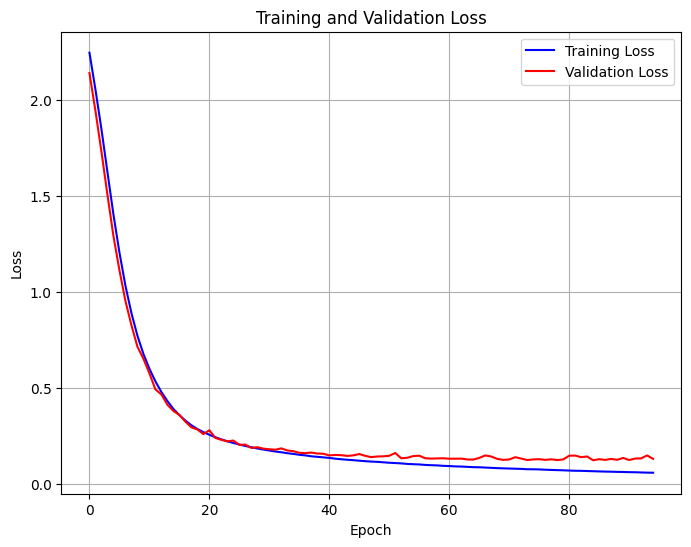

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


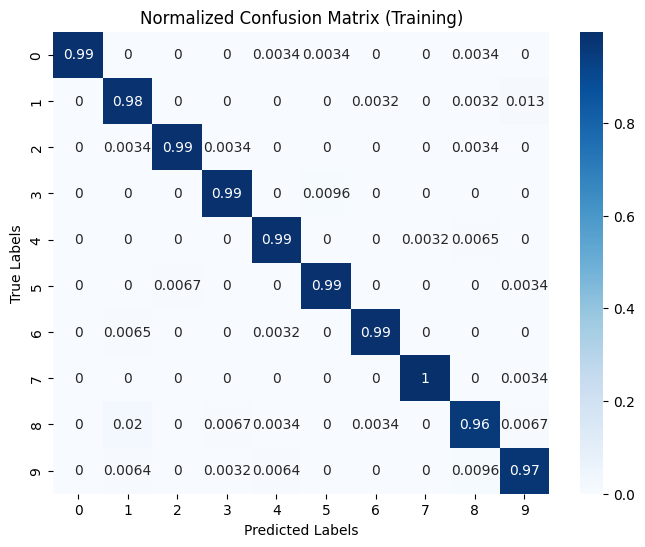

Normalized Training Accuracy: 98.52%
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


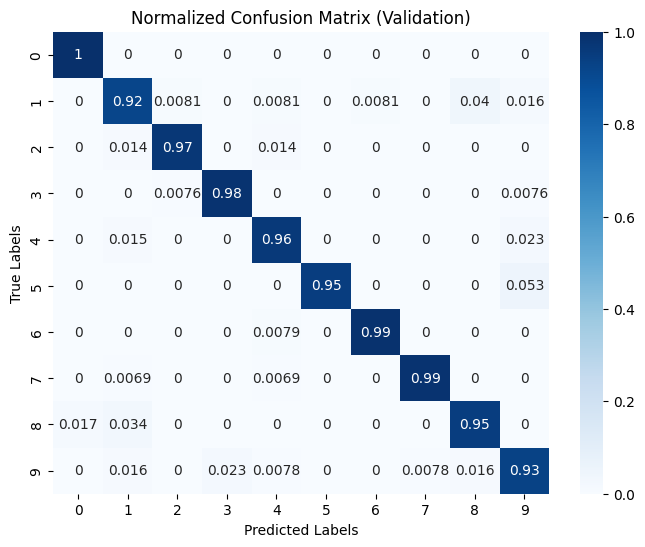

Normalized Validation Accuracy: 96.42%


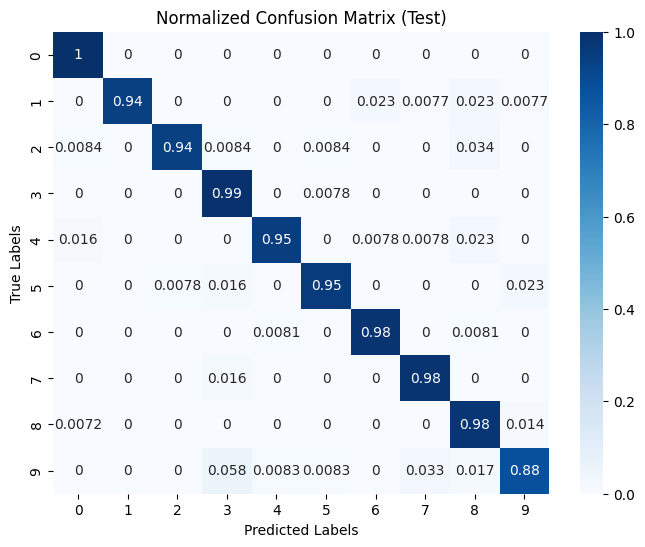

Normalized Test Accuracy: 95.92%
Training time: 7.56 seconds
________________________________________________________________________________________________________________________________________________________________________________________________________
El numero de epocas optimo es:  62
Final Validation Loss: 0.0694, Validation Accuracy: 98.08%
Final Test Loss: 0.0738, Test Accuracy: 97.64%


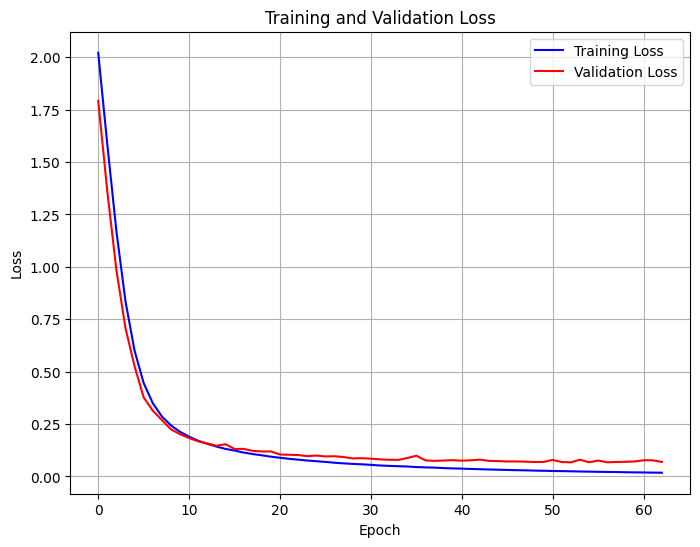

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


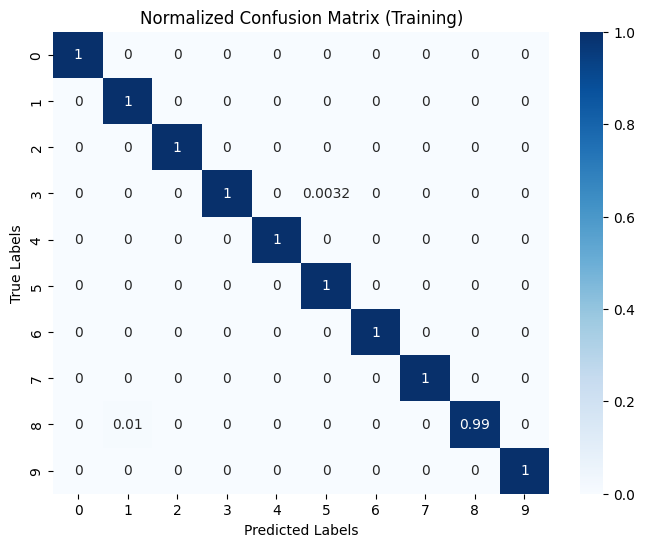

Normalized Training Accuracy: 99.87%
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


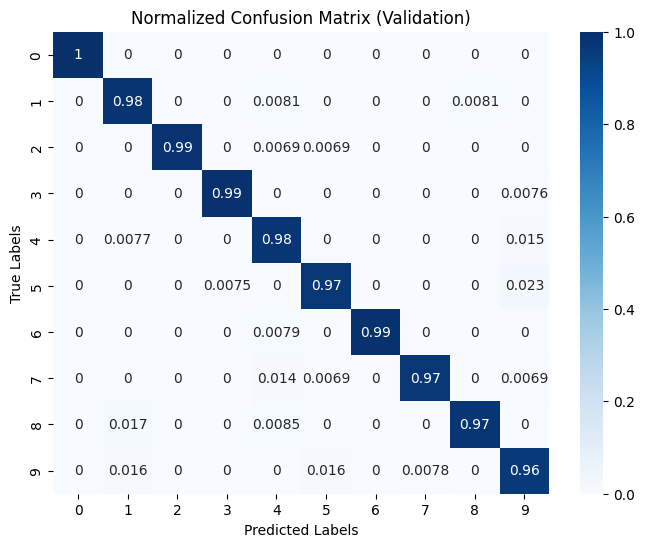

Normalized Validation Accuracy: 98.09%


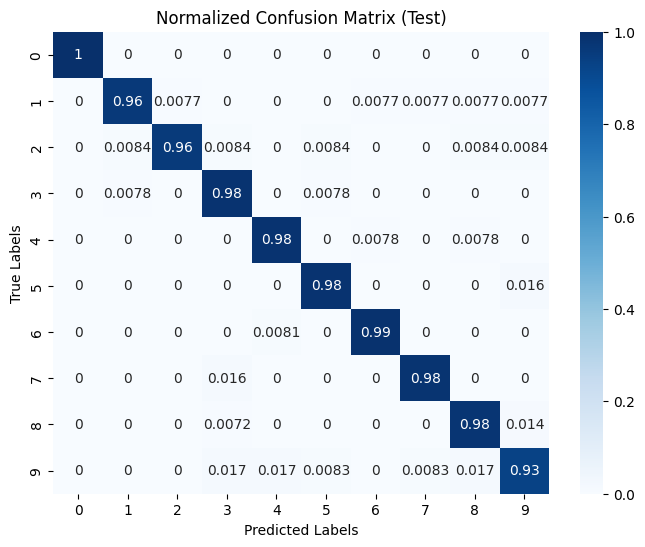

Normalized Test Accuracy: 97.60%
Training time: 5.25 seconds
________________________________________________________________________________________________________________________________________________________________________________________________________
El numero de epocas optimo es:  120
Final Validation Loss: 0.1307, Validation Accuracy: 96.93%
Final Test Loss: 0.1284, Test Accuracy: 96.15%


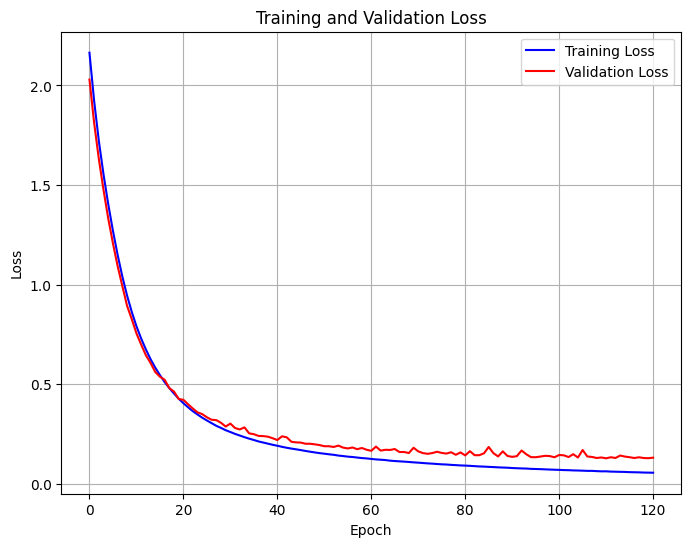

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


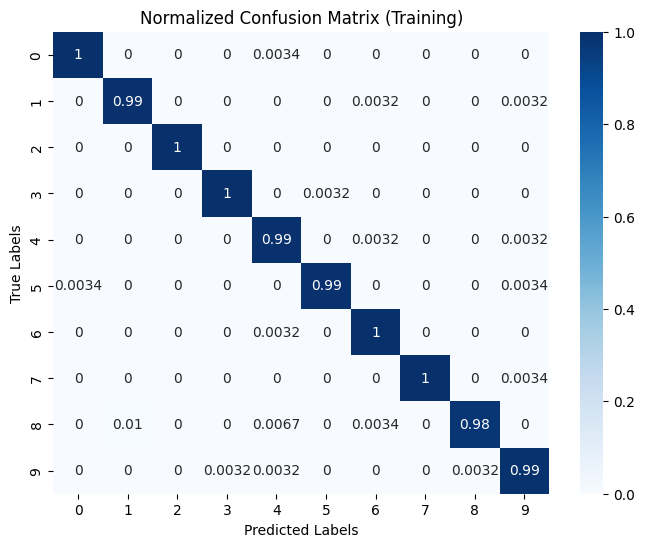

Normalized Training Accuracy: 99.38%
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


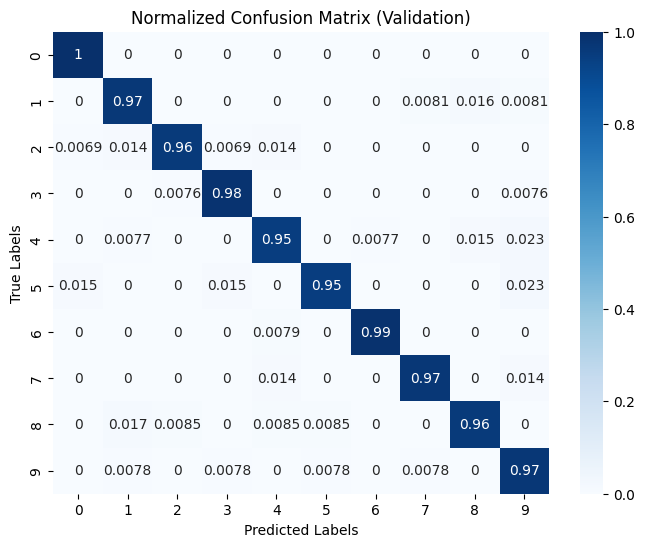

Normalized Validation Accuracy: 96.95%


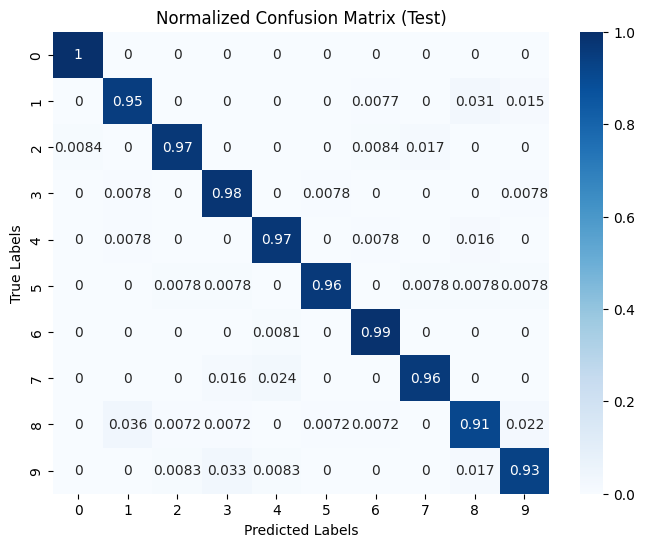

Normalized Test Accuracy: 96.18%
Training time: 8.65 seconds
________________________________________________________________________________________________________________________________________________________________________________________________________
El numero de epocas optimo es:  97
Final Validation Loss: 0.0809, Validation Accuracy: 97.01%
Final Test Loss: 0.0671, Test Accuracy: 97.80%


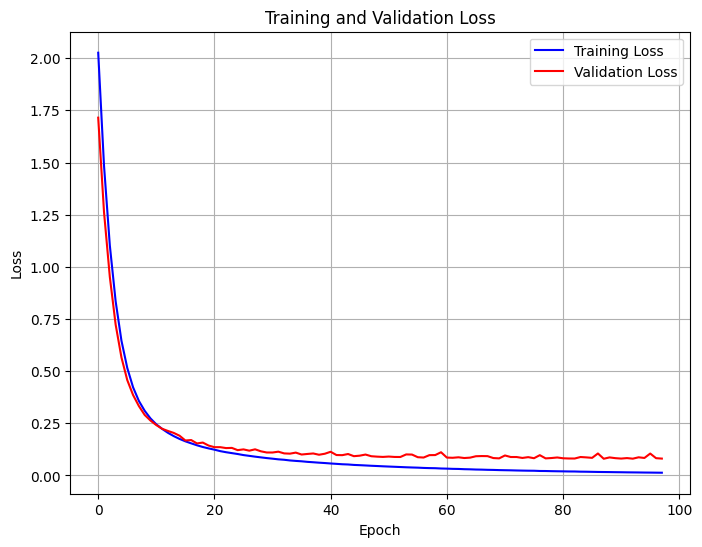

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


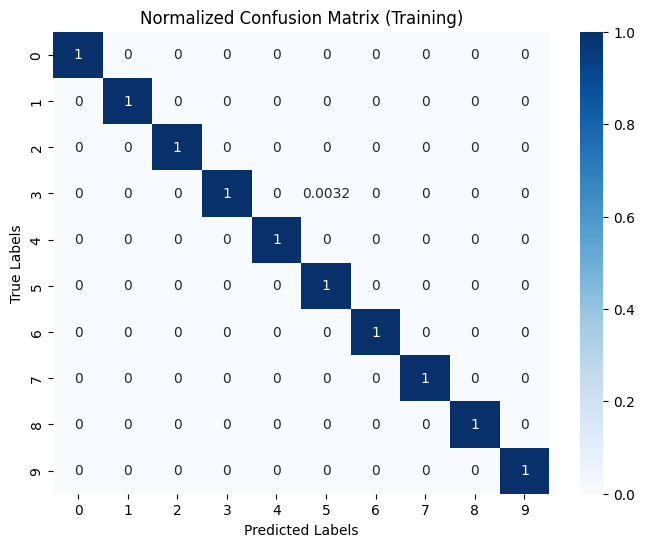

Normalized Training Accuracy: 99.97%
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


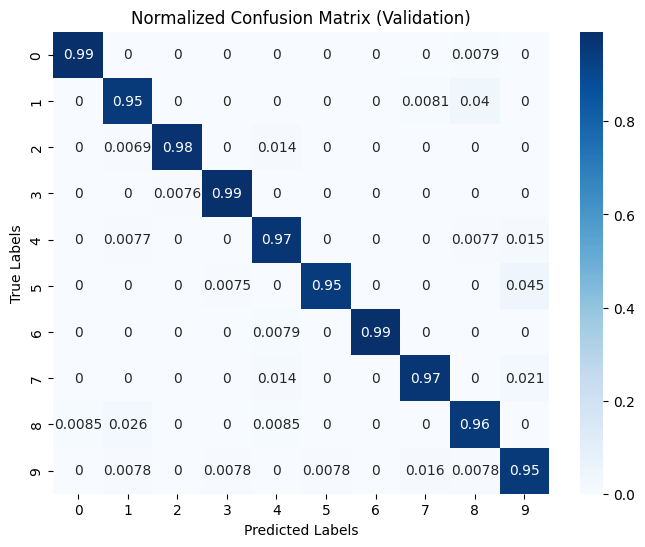

Normalized Validation Accuracy: 97.00%


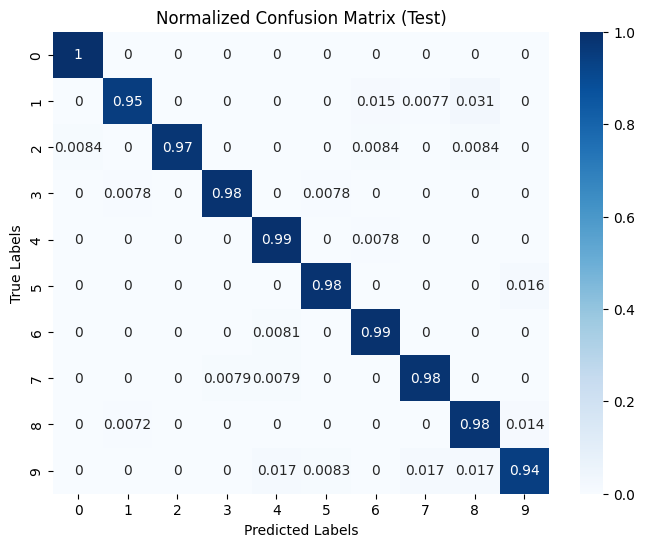

Normalized Test Accuracy: 97.78%
Training time: 7.24 seconds
________________________________________________________________________________________________________________________________________________________________________________________________________
El numero de epocas optimo es:  85
Final Validation Loss: 0.1207, Validation Accuracy: 96.17%
Final Test Loss: 0.1571, Test Accuracy: 95.83%


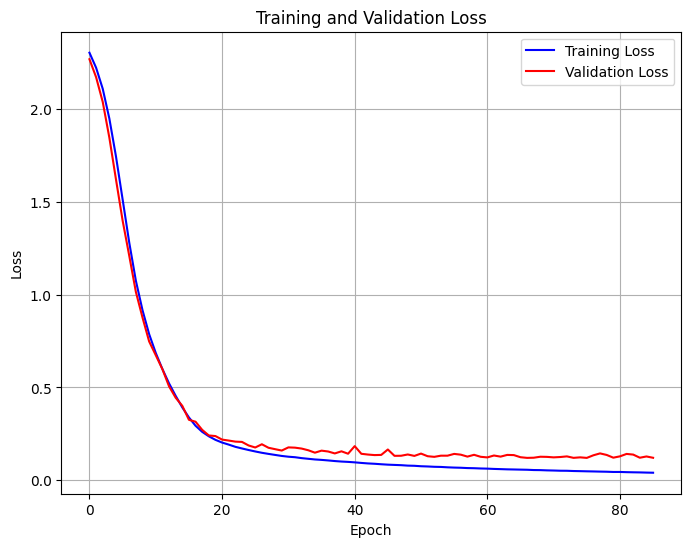

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


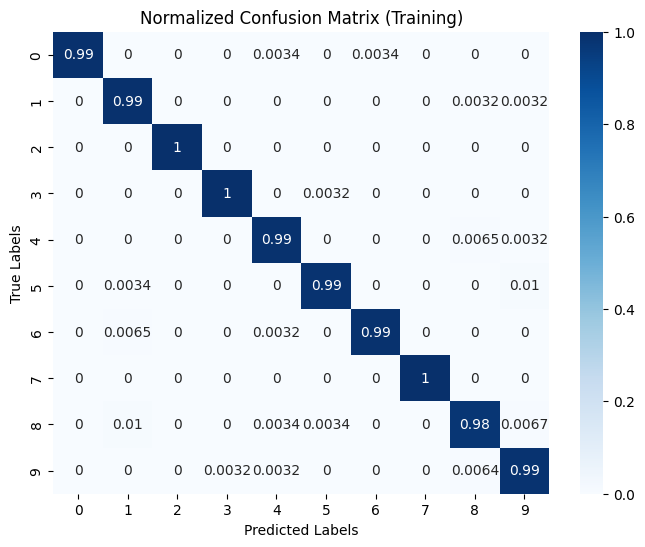

Normalized Training Accuracy: 99.15%
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


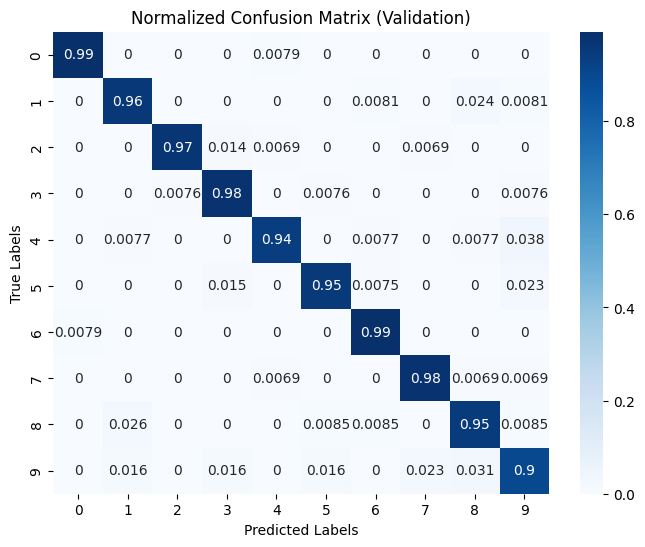

Normalized Validation Accuracy: 96.14%


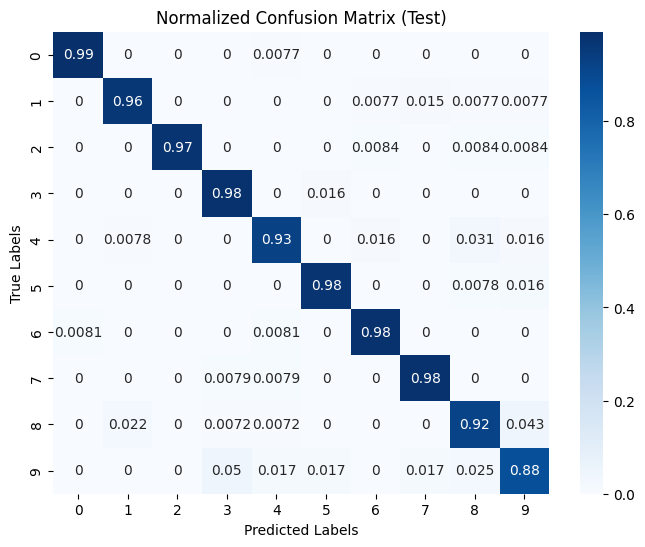

Normalized Test Accuracy: 95.83%
Training time: 7.24 seconds
________________________________________________________________________________________________________________________________________________________________________________________________________
El numero de epocas optimo es:  56
Final Validation Loss: 0.0705, Validation Accuracy: 98.01%
Final Test Loss: 0.0703, Test Accuracy: 98.35%


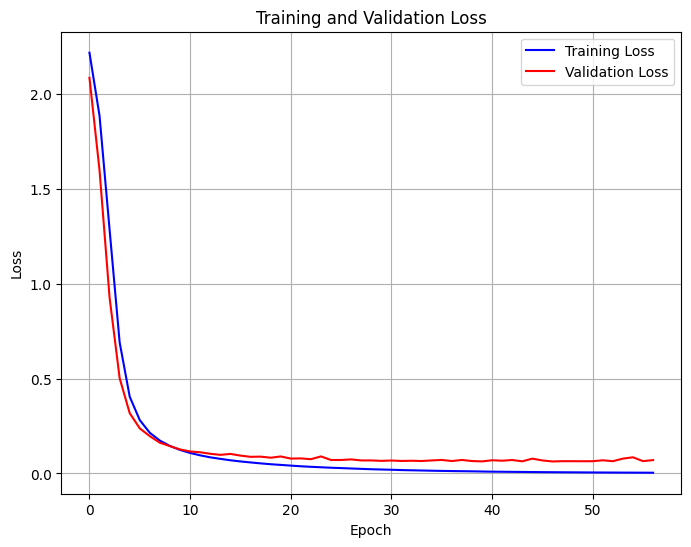

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


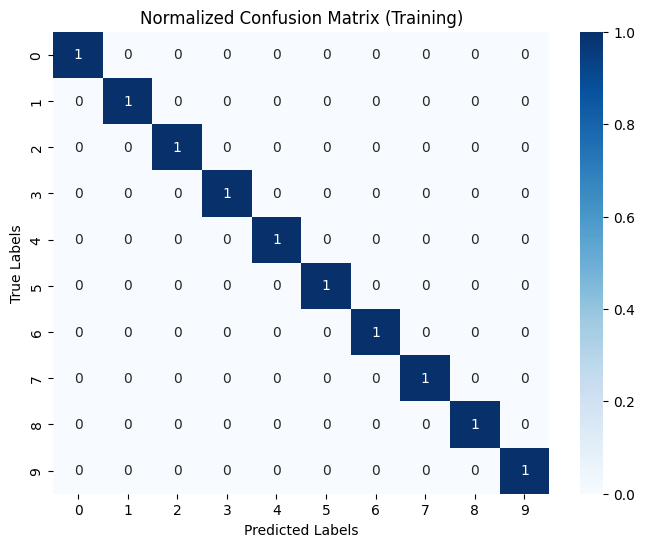

Normalized Training Accuracy: 100.00%
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


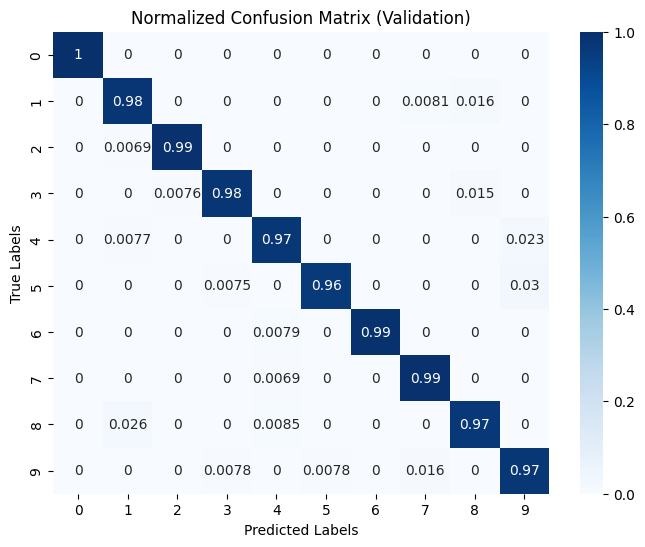

Normalized Validation Accuracy: 97.98%


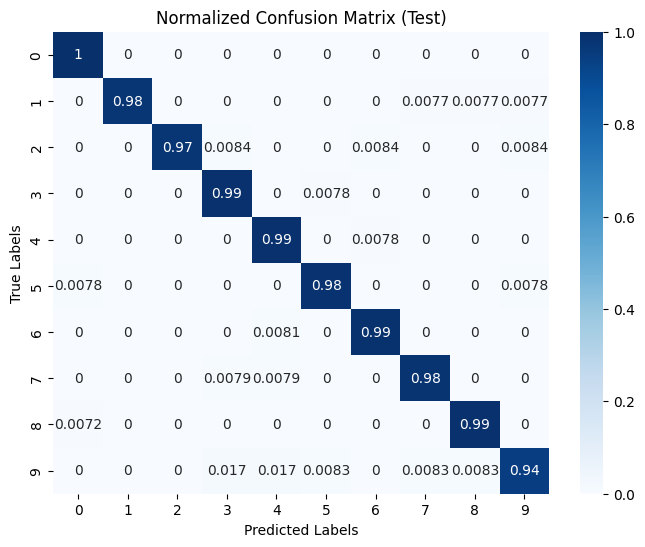

Normalized Test Accuracy: 98.31%
Training time: 5.16 seconds
________________________________________________________________________________________________________________________________________________________________________________________________________


In [49]:
train_and_evaluate_model(model_a, device, dataloader_train, dataloader_val, dataloader_test, optimizer_a, criterion)
train_and_evaluate_model(model_b, device, dataloader_train, dataloader_val, dataloader_test, optimizer_b, criterion)
train_and_evaluate_model(model_c, device, dataloader_train, dataloader_val, dataloader_test, optimizer_c, criterion)
train_and_evaluate_model(model_d, device, dataloader_train, dataloader_val, dataloader_test, optimizer_d, criterion)
train_and_evaluate_model(model_e, device, dataloader_train, dataloader_val, dataloader_test, optimizer_e, criterion)
train_and_evaluate_model(model_f, device, dataloader_train, dataloader_val, dataloader_test, optimizer_f, criterion)